## Initial Prediction Model
The original README file says:
> Often, more than one contact to the same client was required, **in order to access if the product (bank term deposit) would be (or not) subscribed**

Therefore, let's start with a simple binary classification model to predict Deposit yes/no

In [1]:
#import the right libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, log_loss, roc_auc_score, hamming_loss, fbeta_score, auc, roc_curve, precision_score, recall_score
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

In [2]:
#this option just allwos us to see every column in the notebook
pd.set_option('display.max_columns', None)

#pd.get_option("display.max_columns")

In [3]:
#pull in the dataset and turn into a DataFrame
bank_main_df = pd.read_csv('./Dataset_1_Bank Marketing/bank_marketing.csv',delimiter=';')
bank_main_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,58.0,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44.0,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33.0,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47.0,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33.0,unknown,single,unknown,no,1,no,no,NaN,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51.0,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71.0,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72.0,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57.0,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [4]:
bank_main_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,43872.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.924781,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.610835,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
#creating a field that determines whether or not the customer was ever previously contacted
bank_main_df['prior_contact'] = [ 0 if bank_main_df['pdays'][i] == -1 else 1 for i in range(len(bank_main_df))]

#replacing the yes/no categorical values with 1/0 binary digits
bank_main_df['deposit'] = [0 if (bank_main_df['deposit'][i] == 'yes') else 1 for i in range(len(bank_main_df)) ]

#convert the "day" field to a categorical variable
bank_main_df['day'] = pd.Categorical(bank_main_df['day'])

#dropping pdays and previous, because the important information is captured in prior_contact
bank_main_df.drop(columns=['pdays','previous','job','marital','education','default','housing','loan','contact','month','duration'],inplace=True)

In [6]:
#because we have so many cateogrical variables, we should one-hot encode them (i.e. create dummy categorical variables)
#we also use drop_first=True to reduce the redundant column count 
bank_main_df = pd.get_dummies(bank_main_df, drop_first=False)

# bank_main_df

In [7]:
#note that only the "age" category has null values

# pd.isnull(bank_main_df).sum()

# Imputing the missing values in "Age" variable 

* **Iterative Imputer:**
Multivariate imputer that estimates each feature from all the others. A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.

https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

In [8]:
# Use multivariate imputer that estimates and imputes null values based on all the others. 

imp = IterativeImputer(max_iter=10, verbose=0) # values passed are defaults, but added them because they seem important... play around
imp.fit(bank_main_df)
imputed_df = imp.transform(bank_main_df)
imputed_df = pd.DataFrame(imputed_df, columns=bank_main_df.columns)

In [9]:
# pd.isnull(imputed_df).sum()

# R-Forest Feature Importance

In [10]:
#scaler = StandardScaler() 
#X_scaled = scaler.fit_transform(imputed_df)

#X = imputed_df.drop(columns='deposit')
#y = imputed_df['deposit']

#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, shuffle=True, random_state=42) 

# Loop through all classifiers

### MinMaxScaler

In [11]:
# StandardScaler, MinMaxScaler, RobustScaler
#scaler = RobustScaler() 
#X_scaled = scaler.fit_transform(imputed_df)

X = imputed_df.drop(columns='deposit')
y = imputed_df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, shuffle=True)

scaler = MinMaxScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

0.8763639044529637


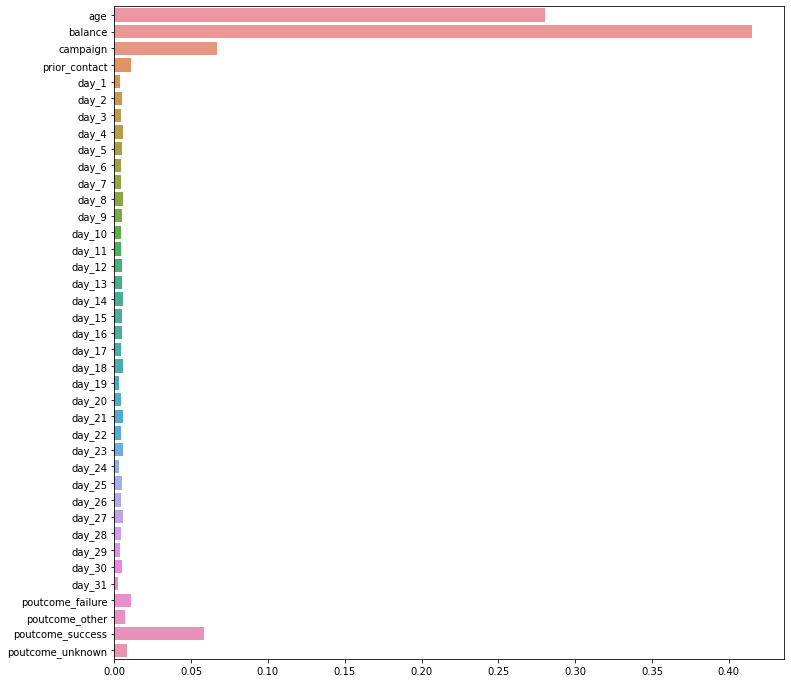

In [12]:
clf = RandomForestClassifier()
# fit the classifier to the training set
clf.fit(X_train, y_train)
# predict on the test set
y_pred = clf.predict(X_test)
acc_ = accuracy_score(y_test, y_pred)
print(acc_)

#for feature in zip(X.columns, clf.feature_importances_.round(3)):
#    print(feature)

plt.figure(figsize=(12,12))
sns.barplot(y=X.columns, x=clf.feature_importances_,orient = 'h');
#plt.xticks(rotation=90);
# visualize feature importance
#with plt.style.context('ggplot', ):
#    sns.set(font_scale=1)
#    plt.figure(num=None, figsize=(14,10), dpi=80, facecolor='w')
#    plt.title("Random Forest Feature Importance Weighting", size=18)
#    plt.ylabel('Features', size = 14)
#    plt.xlabel('Feature Importance', size=14)
#    feat_importances = pd.Series(clf.feature_importances_, index= X.columns)

In [19]:

classifiers = [
#     MultinomialNB(), # doesn't work
    KNeighborsClassifier(3), # works
#     SVC(kernel="rbf", C=0.001, probability=True), # took a long time... need to refresh memory
#     SVC(kernel='linear'), # took a long time... need to refresh memory
#     NuSVC(probability=True, nu=0.1), # took a long time... need to refresh memory
    DecisionTreeClassifier(), # works
    RandomForestClassifier(), # works
    AdaBoostClassifier(), # works
    GradientBoostingClassifier(), # works
    GaussianNB(), # works
    BernoulliNB(), # works
    MLPClassifier(), # works
    MLPClassifier(hidden_layer_sizes=[100, 100]), # works
    LinearDiscriminantAnalysis(), # works
    LogisticRegression(), # works
    QuadraticDiscriminantAnalysis(), # works
]

log_cols=["Classifier", "Accuracy", "F1 Score", "ROC", "Precision", "Recall", "Log Loss", "Sensitivity", "Specificity","True Positives"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
#     y_pred = clf.predict(X)
    name = clf.__class__.__name__

    print("="*60)
    print(name)
    print('****Results****')

    train_predictions = clf.predict(X_test)
    acc_ = accuracy_score(y_test, train_predictions)
    acc = acc_.round(3)
    print("Accuracy: {:.4%}".format(acc))

#     coef_scores = X_scaled
#     coef_scores = clf.coef_
#     print(coef_scores)

    fbeta_ = fbeta_score(y_test, train_predictions, beta=1)
    fbeta = fbeta_.round(3)
    print("F1 Score: {}".format(fbeta))

    roc_ = roc_auc_score(y_test, train_predictions)
    roc = roc_.round(3)
    print("AUC (ROC) Score: {}".format(roc))

    precision_ = precision_score(y_test, train_predictions, average='binary')
    precision = precision_.round(3)
    print("Precision Score: {}".format(precision))

    recall_ = recall_score(y_test, train_predictions)
    recall = recall_.round(3)
    print("Recall Score: {}".format(recall))
    
    TP = confusion_matrix(y_test,train_predictions).ravel()[0]
    FN = confusion_matrix(y_test,train_predictions).ravel()[1]
    sensitivity_ = TP / (TP + FN)
    sensitivity = sensitivity_.round(3)
    print("Sensitivty Score: {}".format(sensitivity))
    
    TN = confusion_matrix(y_test,train_predictions).ravel()[3]
    FP = confusion_matrix(y_test,train_predictions).ravel()[2]
    specificity_ = TN / (TN + FP)
    specificity = specificity_.round(3)
    print("Specificity Score: {}".format(specificity))
    
    true_positives = confusion_matrix(y_test,train_predictions).ravel()[0]
    
    print(f"\nClassic train score: {np.round(clf.score(X_train, y_train),4)}")
    print(f"Classic test score: {np.round(clf.score(X_test, y_test),4)}")
    confusion_matrix_ = confusion_matrix(y_test, train_predictions)
    print(f"Confusion matrix: \n{confusion_matrix_}\n")

#     train_predictions = clf.predict_proba(X_test)
    ll_ = log_loss(y_test, train_predictions)
    ll = ll_.round(3)
#     print("Log Loss: {}".format(ll))

    log_entry = pd.DataFrame([[name, acc*100, fbeta, roc, precision, recall, ll, sensitivity, specificity, true_positives]], columns=log_cols)
    log = pd.concat([log,log_entry])

# print("="*30)
# type(coef_scores)
# print(index)
# print(log_entry)
# type(log)

KNeighborsClassifier
****Results****
Accuracy: 87.1000%
F1 Score: 0.929
AUC (ROC) Score: 0.575
Precision Score: 0.897
Recall Score: 0.963
Sensitivty Score: 0.187
Specificity Score: 0.963

Classic train score: 0.9114
Classic test score: 0.8705
Confusion matrix: 
[[  304  1319]
 [  437 11504]]

DecisionTreeClassifier
****Results****
Accuracy: 81.7000%
F1 Score: 0.896
AUC (ROC) Score: 0.576
Precision Score: 0.899
Recall Score: 0.894
Sensitivty Score: 0.258
Specificity Score: 0.894

Classic train score: 0.9988
Classic test score: 0.8175
Confusion matrix: 
[[  418  1205]
 [ 1271 10670]]

RandomForestClassifier
****Results****
Accuracy: 87.7000%
F1 Score: 0.933
AUC (ROC) Score: 0.578
Precision Score: 0.898
Recall Score: 0.971
Sensitivty Score: 0.185
Specificity Score: 0.971

Classic train score: 0.9987
Classic test score: 0.8772
Confusion matrix: 
[[  301  1322]
 [  344 11597]]

AdaBoostClassifier
****Results****
Accuracy: 88.8000%
F1 Score: 0.939
AUC (ROC) Score: 0.571
Precision Score: 0.89

C:\Users\reagins\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier
****Results****
Accuracy: 87.7000%
F1 Score: 0.933
AUC (ROC) Score: 0.582
Precision Score: 0.898
Recall Score: 0.97
Sensitivty Score: 0.193
Specificity Score: 0.97

Classic train score: 0.9137
Classic test score: 0.8768
Confusion matrix: 
[[  314  1309]
 [  362 11579]]

LinearDiscriminantAnalysis
****Results****
Accuracy: 89.1000%
F1 Score: 0.941
AUC (ROC) Score: 0.586
Precision Score: 0.899
Recall Score: 0.987
Sensitivty Score: 0.185
Specificity Score: 0.987

Classic train score: 0.8934
Classic test score: 0.8911
Confusion matrix: 
[[  301  1322]
 [  155 11786]]

LogisticRegression
****Results****
Accuracy: 89.1000%
F1 Score: 0.941
AUC (ROC) Score: 0.583
Precision Score: 0.898
Recall Score: 0.988
Sensitivty Score: 0.178
Specificity Score: 0.988

Classic train score: 0.8936
Classic test score: 0.8911
Confusion matrix: 
[[  289  1334]
 [  143 11798]]

QuadraticDiscriminantAnalysis
****Results****
Accuracy: 75.2000%
F1 Score: 0.85
AUC (ROC) Score: 0.607
Precision Score: 0.9

C:\Users\reagins\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


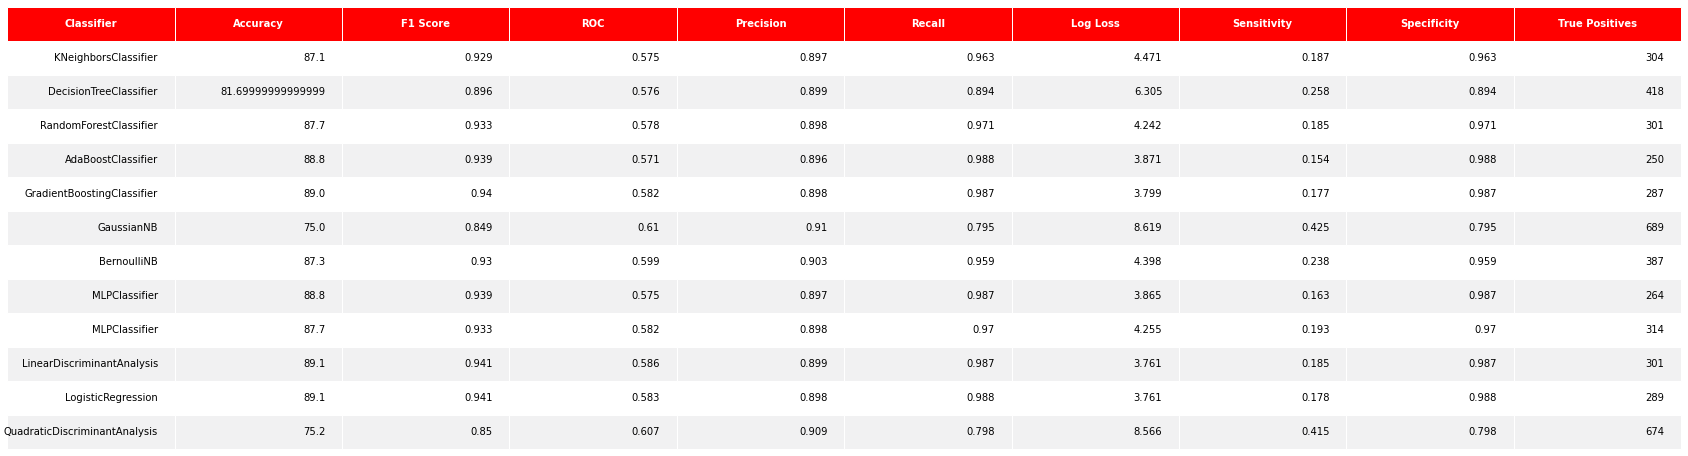

In [20]:
# Save DF as PNG
def render_mpl_table(imputed_df, col_width=6.0, row_height=0.625, font_size=10,
                     header_color='red', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(imputed_df.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=imputed_df.values, bbox=bbox, colLabels=imputed_df.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(log, header_columns=0, col_width=3.0)
fig.savefig("table_mpl.png")

<AxesSubplot:ylabel='Classifier'>

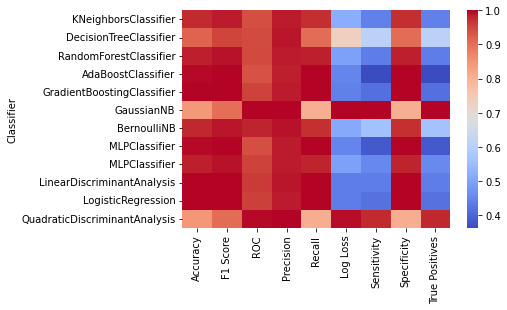

In [21]:
log1 = log.set_index('Classifier')

norm1_df = log1 / log1.max(0)

sns.heatmap(norm1_df.astype('float'),cmap='coolwarm')

### StandardScaler

In [22]:
# StandardScaler, MinMaxScaler, RobustScaler
#scaler = RobustScaler() 
#X_scaled = scaler.fit_transform(imputed_df)

X = imputed_df.drop(columns='deposit')
y = imputed_df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, shuffle=True)

scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:

classifiers = [
#     MultinomialNB(), # doesn't work
    KNeighborsClassifier(3), # works
#     SVC(kernel="rbf", C=0.001, probability=True), # took a long time... need to refresh memory
#     SVC(kernel='linear'), # took a long time... need to refresh memory
#     NuSVC(probability=True, nu=0.1), # took a long time... need to refresh memory
    DecisionTreeClassifier(), # works
    RandomForestClassifier(), # works
    AdaBoostClassifier(), # works
    GradientBoostingClassifier(), # works
    GaussianNB(), # works
    BernoulliNB(), # works
    MLPClassifier(), # works
    MLPClassifier(hidden_layer_sizes=[100, 100]), # works
    LinearDiscriminantAnalysis(), # works
    LogisticRegression(), # works
    QuadraticDiscriminantAnalysis(), # works
]

log_cols=["Classifier", "Accuracy", "F1 Score", "ROC", "Precision", "Recall", "Log Loss", "Sensitivity", "Specificity", "True Positives"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
#     y_pred = clf.predict(X)
    name = clf.__class__.__name__

    print("="*60)
    print(name)
    print('****Results****')

    train_predictions = clf.predict(X_test)
    acc_ = accuracy_score(y_test, train_predictions)
    acc = acc_.round(3)
    print("Accuracy: {:.4%}".format(acc))

#     coef_scores = X_scaled
#     coef_scores = clf.coef_
#     print(coef_scores)

    fbeta_ = fbeta_score(y_test, train_predictions, beta=1)
    fbeta = fbeta_.round(3)
    print("F1 Score: {}".format(fbeta))

    roc_ = roc_auc_score(y_test, train_predictions)
    roc = roc_.round(3)
    print("AUC (ROC) Score: {}".format(roc))

    precision_ = precision_score(y_test, train_predictions, average='binary')
    precision = precision_.round(3)
    print("Precision Score: {}".format(precision))

    recall_ = recall_score(y_test, train_predictions)
    recall = recall_.round(3)
    print("Recall Score: {}".format(recall))
    
    TP = confusion_matrix(y_test,train_predictions).ravel()[0]
    FN = confusion_matrix(y_test,train_predictions).ravel()[1]
    sensitivity_ = TP / (TP + FN)
    sensitivity = sensitivity_.round(3)
    print("Sensitivty Score: {}".format(sensitivity))
    
    TN = confusion_matrix(y_test,train_predictions).ravel()[3]
    FP = confusion_matrix(y_test,train_predictions).ravel()[2]
    specificity_ = TN / (TN + FP)
    specificity = specificity_.round(3)
    print("Specificity Score: {}".format(specificity))
    
    true_positives = confusion_matrix(y_test,train_predictions).ravel()[0]
    
    print(f"\nClassic train score: {np.round(clf.score(X_train, y_train),4)}")
    print(f"Classic test score: {np.round(clf.score(X_test, y_test),4)}")
    confusion_matrix_ = confusion_matrix(y_test, train_predictions)
    print(f"Confusion matrix: \n{confusion_matrix_}\n")

#     train_predictions = clf.predict_proba(X_test)
    ll_ = log_loss(y_test, train_predictions)
    ll = ll_.round(3)
#     print("Log Loss: {}".format(ll))

    log_entry = pd.DataFrame([[name, acc*100, fbeta, roc, precision, recall, ll, sensitivity, specificity, true_positives]], columns=log_cols)
    log = pd.concat([log,log_entry])

# print("="*30)
# type(coef_scores)
# print(index)
# print(log_entry)
# type(log)

KNeighborsClassifier
****Results****
Accuracy: 87.3000%
F1 Score: 0.931
AUC (ROC) Score: 0.585
Precision Score: 0.902
Recall Score: 0.961
Sensitivty Score: 0.208
Specificity Score: 0.961

Classic train score: 0.9113
Classic test score: 0.8733
Confusion matrix: 
[[  329  1253]
 [  466 11516]]

DecisionTreeClassifier
****Results****
Accuracy: 81.8000%
F1 Score: 0.896
AUC (ROC) Score: 0.582
Precision Score: 0.903
Recall Score: 0.89
Sensitivty Score: 0.273
Specificity Score: 0.89

Classic train score: 0.9987
Classic test score: 0.8182
Confusion matrix: 
[[  432  1150]
 [ 1316 10666]]

RandomForestClassifier
****Results****
Accuracy: 88.3000%
F1 Score: 0.936
AUC (ROC) Score: 0.588
Precision Score: 0.902
Recall Score: 0.972
Sensitivty Score: 0.204
Specificity Score: 0.972

Classic train score: 0.9987
Classic test score: 0.8826
Confusion matrix: 
[[  322  1260]
 [  333 11649]]

AdaBoostClassifier
****Results****
Accuracy: 89.3000%
F1 Score: 0.942
AUC (ROC) Score: 0.581
Precision Score: 0.901


C:\Users\reagins\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier
****Results****
Accuracy: 88.0000%
F1 Score: 0.935
AUC (ROC) Score: 0.589
Precision Score: 0.903
Recall Score: 0.969
Sensitivty Score: 0.209
Specificity Score: 0.969

Classic train score: 0.9129
Classic test score: 0.8802
Confusion matrix: 
[[  330  1252]
 [  373 11609]]

LinearDiscriminantAnalysis
****Results****
Accuracy: 89.4000%
F1 Score: 0.943
AUC (ROC) Score: 0.588
Precision Score: 0.902
Recall Score: 0.987
Sensitivty Score: 0.19
Specificity Score: 0.987

Classic train score: 0.8923
Classic test score: 0.8937
Confusion matrix: 
[[  300  1282]
 [  160 11822]]

LogisticRegression
****Results****
Accuracy: 89.4000%
F1 Score: 0.943
AUC (ROC) Score: 0.586
Precision Score: 0.902
Recall Score: 0.987
Sensitivty Score: 0.185
Specificity Score: 0.987

Classic train score: 0.8926
Classic test score: 0.8937
Confusion matrix: 
[[  293  1289]
 [  153 11829]]

QuadraticDiscriminantAnalysis
****Results****
Accuracy: 80.0000%
F1 Score: 0.883
AUC (ROC) Score: 0.615
Precision Score: 0

C:\Users\reagins\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


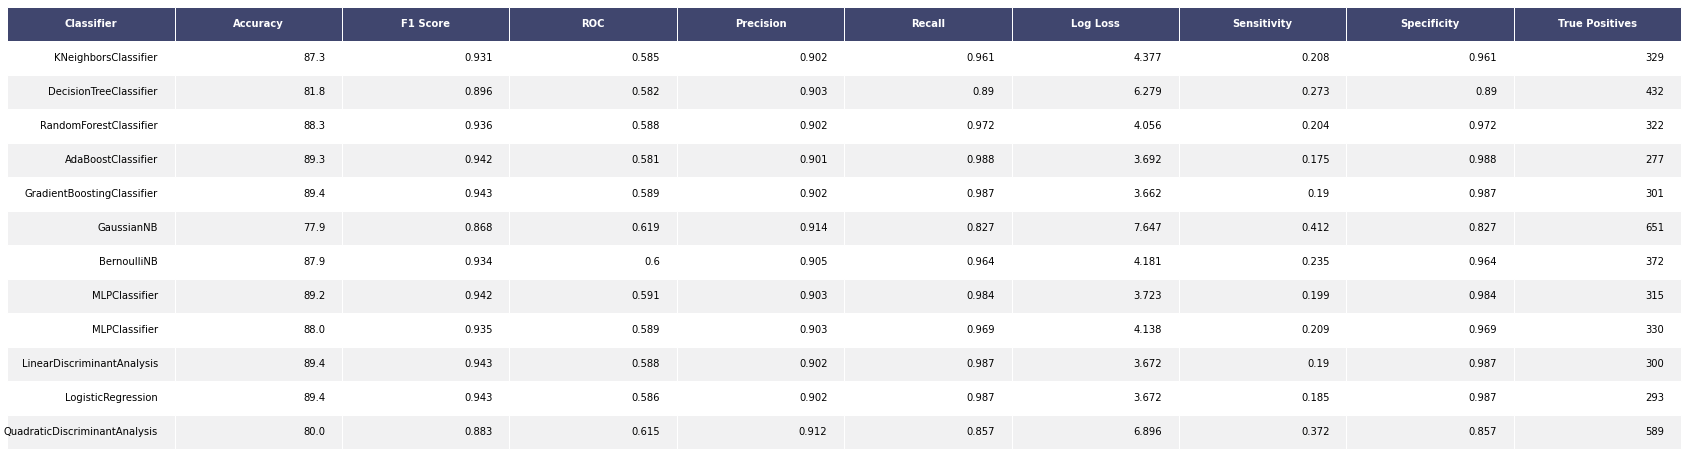

In [24]:
# Save DF as PNG
def render_mpl_table(imputed_df, col_width=6.0, row_height=0.625, font_size=10,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(imputed_df.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=imputed_df.values, bbox=bbox, colLabels=imputed_df.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(log, header_columns=0, col_width=3.0)
fig.savefig("table_mpl.png")

<AxesSubplot:ylabel='Classifier'>

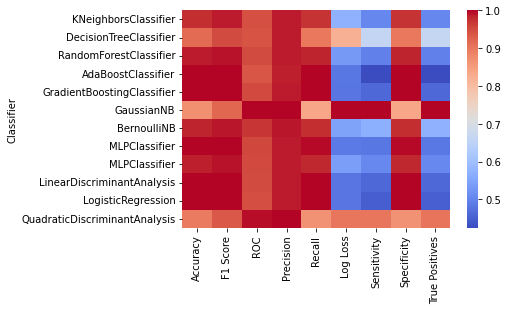

In [25]:
log2 = log.set_index('Classifier')

norm2_df = log2 / log2.max(0)

sns.heatmap(norm2_df.astype('float'),cmap='coolwarm')

### RobustScaler

In [26]:
# StandardScaler, MinMaxScaler, RobustScaler
#scaler = RobustScaler() 
#X_scaled = scaler.fit_transform(imputed_df)

X = imputed_df.drop(columns='deposit')
y = imputed_df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, shuffle=True)

scaler = RobustScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:

classifiers = [
#     MultinomialNB(), # doesn't work
    KNeighborsClassifier(3), # works
#     SVC(kernel="rbf", C=0.001, probability=True), # took a long time... need to refresh memory
#     SVC(kernel='linear'), # took a long time... need to refresh memory
#     NuSVC(probability=True, nu=0.1), # took a long time... need to refresh memory
    DecisionTreeClassifier(), # works
    RandomForestClassifier(), # works
    AdaBoostClassifier(), # works
    GradientBoostingClassifier(), # works
    GaussianNB(), # works
    BernoulliNB(), # works
    MLPClassifier(), # works
    MLPClassifier(hidden_layer_sizes=[100, 100]), # works
    LinearDiscriminantAnalysis(), # works
    LogisticRegression(), # works
    QuadraticDiscriminantAnalysis(), # works
]

log_cols=["Classifier", "Accuracy", "F1 Score", "ROC", "Precision", "Recall", "Log Loss", "Sensitivity", "Specificity", "True Positives"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
#     y_pred = clf.predict(X)
    name = clf.__class__.__name__

    print("="*60)
    print(name)
    print('****Results****')

    train_predictions = clf.predict(X_test)
    acc_ = accuracy_score(y_test, train_predictions)
    acc = acc_.round(3)
    print("Accuracy: {:.4%}".format(acc))

#     coef_scores = X_scaled
#     coef_scores = clf.coef_
#     print(coef_scores)

    fbeta_ = fbeta_score(y_test, train_predictions, beta=1)
    fbeta = fbeta_.round(3)
    print("F1 Score: {}".format(fbeta))

    roc_ = roc_auc_score(y_test, train_predictions)
    roc = roc_.round(3)
    print("AUC (ROC) Score: {}".format(roc))

    precision_ = precision_score(y_test, train_predictions, average='binary')
    precision = precision_.round(3)
    print("Precision Score: {}".format(precision))

    recall_ = recall_score(y_test, train_predictions)
    recall = recall_.round(3)
    print("Recall Score: {}".format(recall))
    
    TP = confusion_matrix(y_test,train_predictions).ravel()[0]
    FN = confusion_matrix(y_test,train_predictions).ravel()[1]
    sensitivity_ = TP / (TP + FN)
    sensitivity = sensitivity_.round(3)
    print("Sensitivty Score: {}".format(sensitivity))
    
    TN = confusion_matrix(y_test,train_predictions).ravel()[3]
    FP = confusion_matrix(y_test,train_predictions).ravel()[2]
    specificity_ = TN / (TN + FP)
    specificity = specificity_.round(3)
    print("Specificity Score: {}".format(specificity))
    
    true_positives = confusion_matrix(y_test,train_predictions).ravel()[0]
    
    print(f"\nClassic train score: {np.round(clf.score(X_train, y_train),4)}")
    print(f"Classic test score: {np.round(clf.score(X_test, y_test),4)}")
    confusion_matrix_ = confusion_matrix(y_test, train_predictions)
    print(f"Confusion matrix: \n{confusion_matrix_}\n")

#     train_predictions = clf.predict_proba(X_test)
    ll_ = log_loss(y_test, train_predictions)
    ll = ll_.round(3)
#     print("Log Loss: {}".format(ll))

    log_entry = pd.DataFrame([[name, acc*100, fbeta, roc, precision, recall, ll, sensitivity, specificity, true_positives]], columns=log_cols)
    log = pd.concat([log,log_entry])

# print("="*30)
# type(coef_scores)
# print(index)
# print(log_entry)
# type(log)

KNeighborsClassifier
****Results****
Accuracy: 87.2000%
F1 Score: 0.93
AUC (ROC) Score: 0.579
Precision Score: 0.901
Recall Score: 0.96
Sensitivty Score: 0.199
Specificity Score: 0.96

Classic train score: 0.9112
Classic test score: 0.8716
Confusion matrix: 
[[  313  1258]
 [  484 11509]]

DecisionTreeClassifier
****Results****
Accuracy: 82.1000%
F1 Score: 0.898
AUC (ROC) Score: 0.575
Precision Score: 0.902
Recall Score: 0.895
Sensitivty Score: 0.256
Specificity Score: 0.895

Classic train score: 0.9982
Classic test score: 0.8208
Confusion matrix: 
[[  402  1169]
 [ 1261 10732]]

RandomForestClassifier
****Results****
Accuracy: 88.1000%
F1 Score: 0.935
AUC (ROC) Score: 0.585
Precision Score: 0.902
Recall Score: 0.97
Sensitivty Score: 0.2
Specificity Score: 0.97

Classic train score: 0.9981
Classic test score: 0.8809
Confusion matrix: 
[[  314  1257]
 [  359 11634]]

AdaBoostClassifier
****Results****
Accuracy: 89.4000%
F1 Score: 0.943
AUC (ROC) Score: 0.583
Precision Score: 0.902
Recal

C:\Users\reagins\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier
****Results****
Accuracy: 89.0000%
F1 Score: 0.94
AUC (ROC) Score: 0.582
Precision Score: 0.902
Recall Score: 0.983
Sensitivty Score: 0.181
Specificity Score: 0.983

Classic train score: 0.8979
Classic test score: 0.8899
Confusion matrix: 
[[  284  1287]
 [  207 11786]]



C:\Users\reagins\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier
****Results****
Accuracy: 88.1000%
F1 Score: 0.935
AUC (ROC) Score: 0.574
Precision Score: 0.9
Recall Score: 0.973
Sensitivty Score: 0.175
Specificity Score: 0.973

Classic train score: 0.9156
Classic test score: 0.881
Confusion matrix: 
[[  275  1296]
 [  318 11675]]

LinearDiscriminantAnalysis
****Results****
Accuracy: 89.4000%
F1 Score: 0.943
AUC (ROC) Score: 0.59
Precision Score: 0.903
Recall Score: 0.986
Sensitivty Score: 0.195
Specificity Score: 0.986

Classic train score: 0.8921
Classic test score: 0.894
Confusion matrix: 
[[  306  1265]
 [  173 11820]]

LogisticRegression
****Results****
Accuracy: 89.4000%
F1 Score: 0.943
AUC (ROC) Score: 0.585
Precision Score: 0.902
Recall Score: 0.987
Sensitivty Score: 0.183
Specificity Score: 0.987

Classic train score: 0.8924
Classic test score: 0.8936
Confusion matrix: 
[[  287  1284]
 [  159 11834]]

QuadraticDiscriminantAnalysis
****Results****
Accuracy: 81.0000%
F1 Score: 0.89
AUC (ROC) Score: 0.612
Precision Score: 0.911


C:\Users\reagins\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


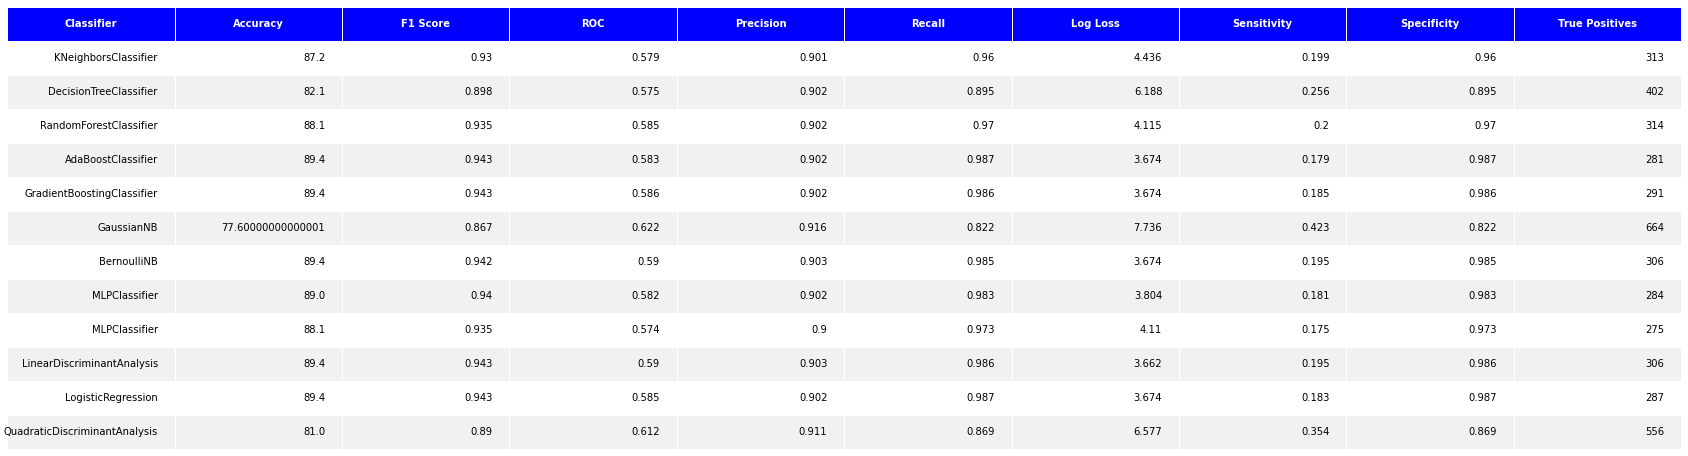

In [28]:
# Save DF as PNG
def render_mpl_table(imputed_df, col_width=6.0, row_height=0.625, font_size=10,
                     header_color='blue', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(imputed_df.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=imputed_df.values, bbox=bbox, colLabels=imputed_df.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(log, header_columns=0, col_width=3.0)
fig.savefig("table_mpl.png")

<AxesSubplot:ylabel='Classifier'>

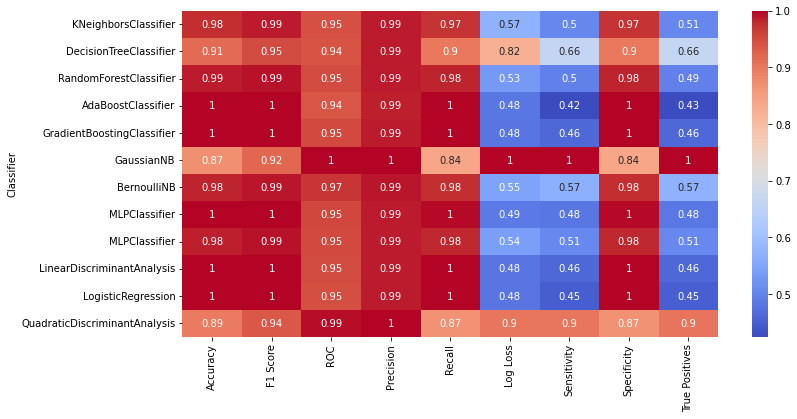

In [44]:
log3 = log.set_index('Classifier')

norm3_df = log3 / log3.max(0)

plt.figure(figsize=(12,6))
sns.heatmap(norm2_df.astype('float'),cmap='coolwarm',annot=True)

<AxesSubplot:ylabel='Classifier'>

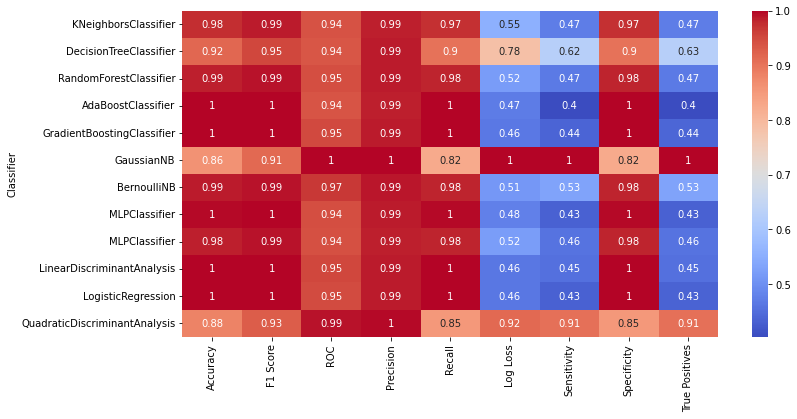

In [51]:
big_norm_df = (norm1_df + norm2_df + norm3_df) / 3

plt.figure(figsize=(12,6))
sns.heatmap(big_norm_df.astype('float'),cmap='coolwarm',annot=True)

In [58]:
big_log_df = (log1 + log2 + log3) / 3

big_log_df

,Accuracy,F1 Score,ROC,Precision,Recall,Log Loss,Sensitivity,Specificity,True Positives
Classifier,,,,,,,,,
KNeighborsClassifier,87.2,0.93,0.579667,0.9,0.961333,4.428,0.198,0.961333,315.333333
DecisionTreeClassifier,81.866667,0.896667,0.577667,0.901333,0.893,6.257333,0.262333,0.893,417.333333
RandomForestClassifier,88.033333,0.934667,0.583667,0.900667,0.971,4.137667,0.196333,0.971,312.333333
AdaBoostClassifier,89.166667,0.941333,0.578333,0.899667,0.987667,3.745667,0.169333,0.987667,269.333333
GradientBoostingClassifier,89.266667,0.942,0.585667,0.900667,0.986667,3.711667,0.184,0.986667,293.0
GaussianNB,76.833333,0.861333,0.617,0.913333,0.814667,8.000667,0.42,0.814667,668.0
BernoulliNB,88.2,0.935333,0.596333,0.903667,0.969333,4.084333,0.222667,0.969333,355.0
MLPClassifier,89.0,0.940333,0.582667,0.900667,0.984667,3.797333,0.181,0.984667,287.666667
MLPClassifier,87.933333,0.934333,0.581667,0.900333,0.970667,4.167667,0.192333,0.970667,306.333333


In [ ]:
#plt.figure(figsize=(24,3))
#sns.barplot(X.columns,logreg.coef_[0])
#plt.xticks(rotation=60)
#plt.title("Extracting the Feature Importance");

### Further discussion for the group
* **What further refinements to the dataset should we make as part of the EDA / cleanup?**
    * Removing the *pdays* variable, for example
    * Dropping outliers 
* **How might the use of other classification algorithms and scalers affect the final predictions?**
    * ~Algorithms like LogisticRegression, DecisionTree, RandomForest, Kneighbors, NaiveBayes, neural net, etc.~
    * Scalers like StandardScaler, MinMaxScaler, RobustScaler
    * PCA (principal component analysis) to reduce dimensions
* **Playing with parameters, pipelines, gridsearches to maximize True Negatives and minimize False Negatives**
    * That is, maximize deposit==1 correct predictions and reducing deposit==0 wrong predictions
    * Even if that means accidentally overpredicting the number of true deposits, better to try a bad path than miss a potential business opportunity
* **Extending this to other predictions**
    * e.g. predicting the "default" variable, or some other classification
    * e.g. predicting a range for continuous values based on categorical values
* **Best ways to impute missing data?**
    * 